# SPATIAL ANALYSIS OF ISS DATASETS

This tutorial is an example of how to use Squidpy to analyze In Situ Sequencing datasets, performing several different statistical tests to understand the spatial organization of tissues. This tutorial follows the scanpy tutorial/pciseq tutorials, so we'll take as an input an h5 object created. More information, if needed, can be found at: https://squidpy.readthedocs.io/en/stable/tutorials.html

# Loading the needed packages

The first step is to load the needed packages. If any of them fails, please go and check that they are installed in the appropiate environment

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import squidpy as sq
import scanpy as sc
import os

# Load your dataset

We are going to load our dataset, were we have alredy performed clustering, from an h5ad file. If you want to check how to format your data in this format, please check the Scanpy tutorial

In [5]:
adata=sc.read('/home/christoffer/mouse_development_h5ad_illastik_segmentation.h5ad')
adata

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '\home\christoffer\mouse_development_h5ad_illastik_segmentation.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In this specific case, we have several samples in the object, so we want to run everything for a single one. We select to just keep cells from the section called 10E in the adata object

In [15]:
adata=adata[adata.obs['sample']=='10E']

One preprocessing step that we need to do in squidpy is specifying in which columns your x and y coordinates are. The cooordinates will be saved as "spatial"

In [23]:
adata.obsm["spatial"]=np.array([adata.obs.x,adata.obs.y,adata.obs.y]).transpose().astype('float64')

Another preliminary step that is good to do is to consider the terms in the variable where we have our cell types/clusters as category

In [24]:
adata.obsm["spatial"]

array([[ 3972.83828775,  1682.02497027,  1682.02497027],
       [ 3974.69155556,  1738.70311111,  1738.70311111],
       [ 3923.23054755,  1751.36455331,  1751.36455331],
       ...,
       [ 9557.01933702, 13003.66850829, 13003.66850829],
       [ 9789.93717277, 13032.41186736, 13032.41186736],
       [ 9665.15245478, 13038.50516796, 13038.50516796]])

In [25]:
adata.obs["leiden_0.8"]=adata.obs["leiden_0.8"].astype('category')

# Plotting our clusters

To verify that everything is correct, we will plot our clusters in space using the fuction included in scanpy for plotting clusters

<Figure size 3600x3600 with 0 Axes>

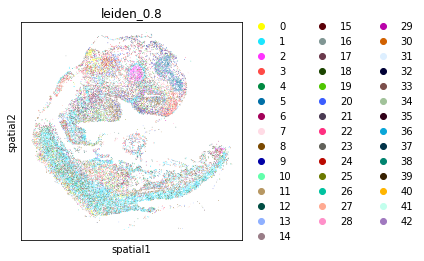

In [26]:
plt.figure(figsize=(50,50))
sc.pl.spatial(
    adata,
    color="leiden_0.8",
    neighbors_key="spatial_neighbors",
    spot_size=40,
    edges=False,
    edges_width=2,
    img_key=None,
)

# Neiborhood enrichment

[FROM SQUIDPY TUTORIALS] We can investigate spatial organization of clusters in a quantitative way, by computing a neighborhood enrichment score. You can compute such score with the following function: squidpy.gr.nhood_enrichment(). In short, it’s an enrichment score on spatial proximity of clusters: if spots belonging to two different clusters are often close to each other, then they will have a high score and can be defined as being enriched. On the other hand, if they are far apart, the score will be low and they can be defined as depleted. This score is based on a permutation-based test, and you can set the number of permutations with the n_perms argument (default is 1000).

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 579.82/s]
/home/sergio/anaconda3/envs/squidpy/lib/python3.7/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


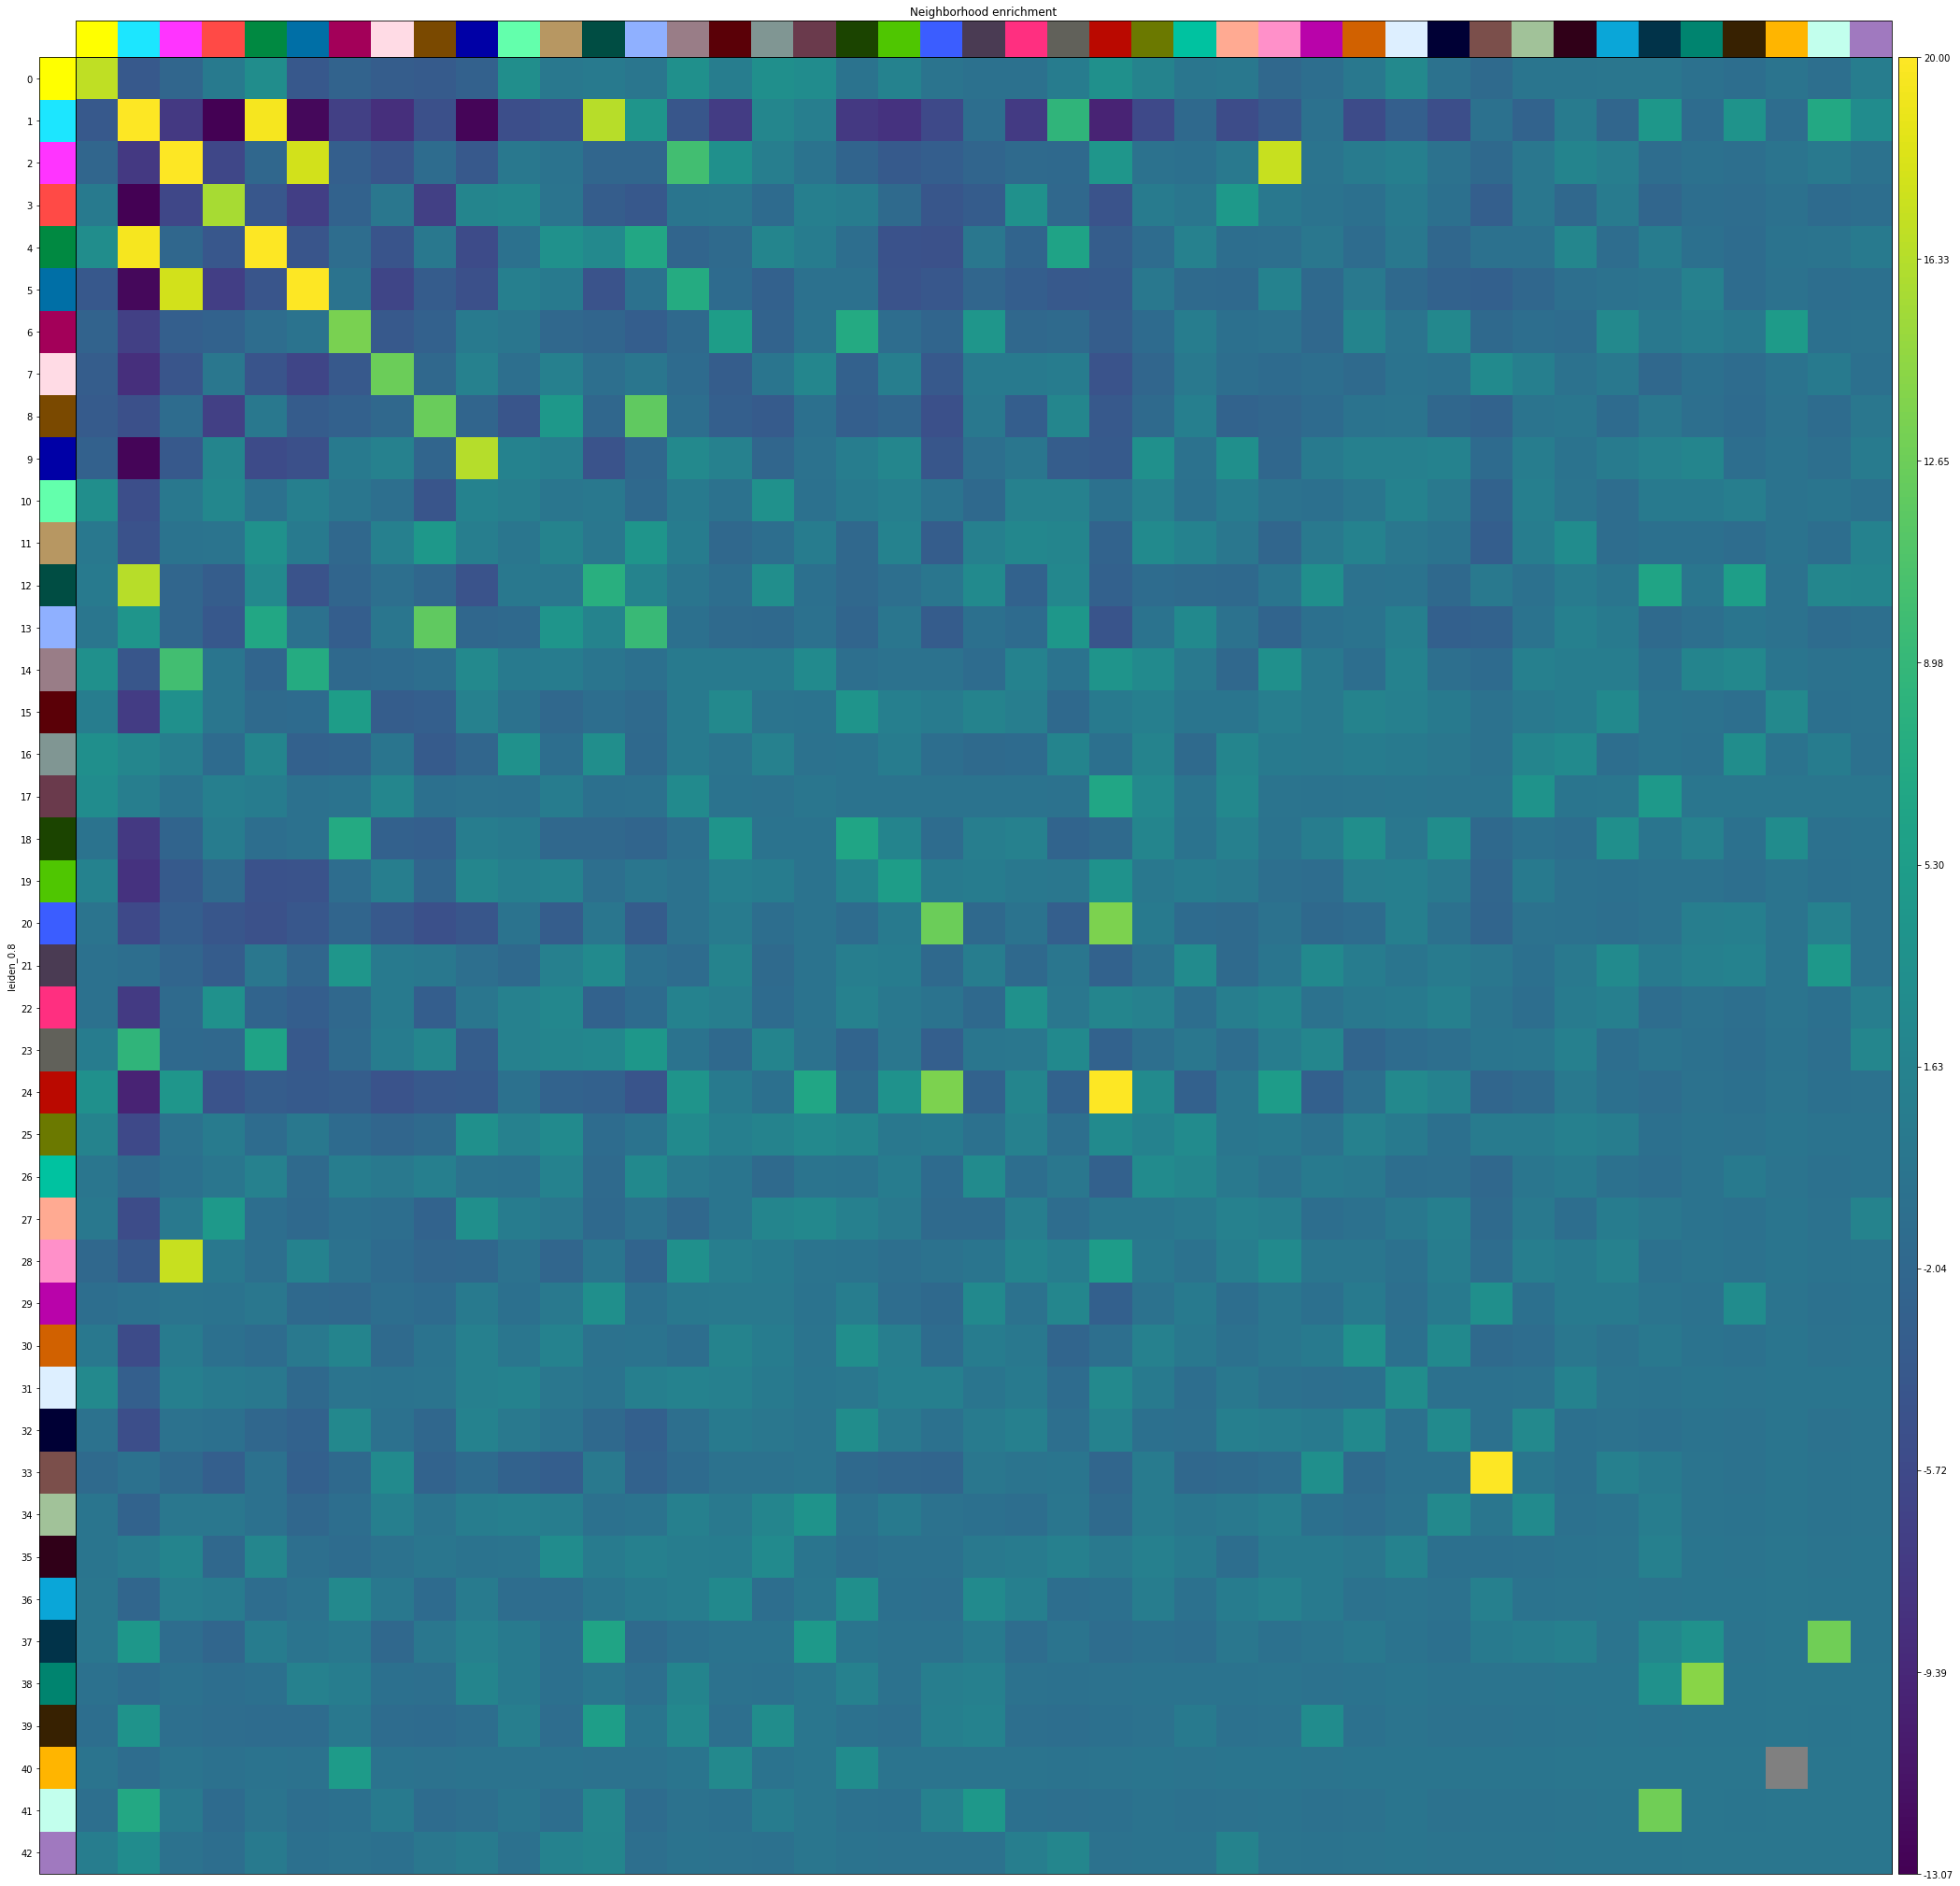

In [22]:
sq.gr.spatial_neighbors(adata,radius=50.0)
sq.gr.nhood_enrichment(adata, cluster_key="leiden_0.8")
sq.pl.nhood_enrichment(adata, cluster_key="leiden_0.8",vmax=20)

Using this type of analysis, we can find colocalizing clusters (the ones with higher values). The higher the values are, the more enriched a cluster is next to a second cluster. This plot typically gives very high values for a pair of clusters and much lower values, but still interesting, for others, so it's important to play with the "vmax" parameter of the pl function and reduce the maximum value we can visualize to highlight differences between other clusters

# Interaction matrix

Squidpy provides other descriptive statistics of the spatial graph. For instance, the interaction matrix, which counts the number of edges that each cluster share with all the others. This score can be computed with the function squidpy.gr.interaction_matrix(). We can visualize the results with squidpy.pl.interaction_matrix()

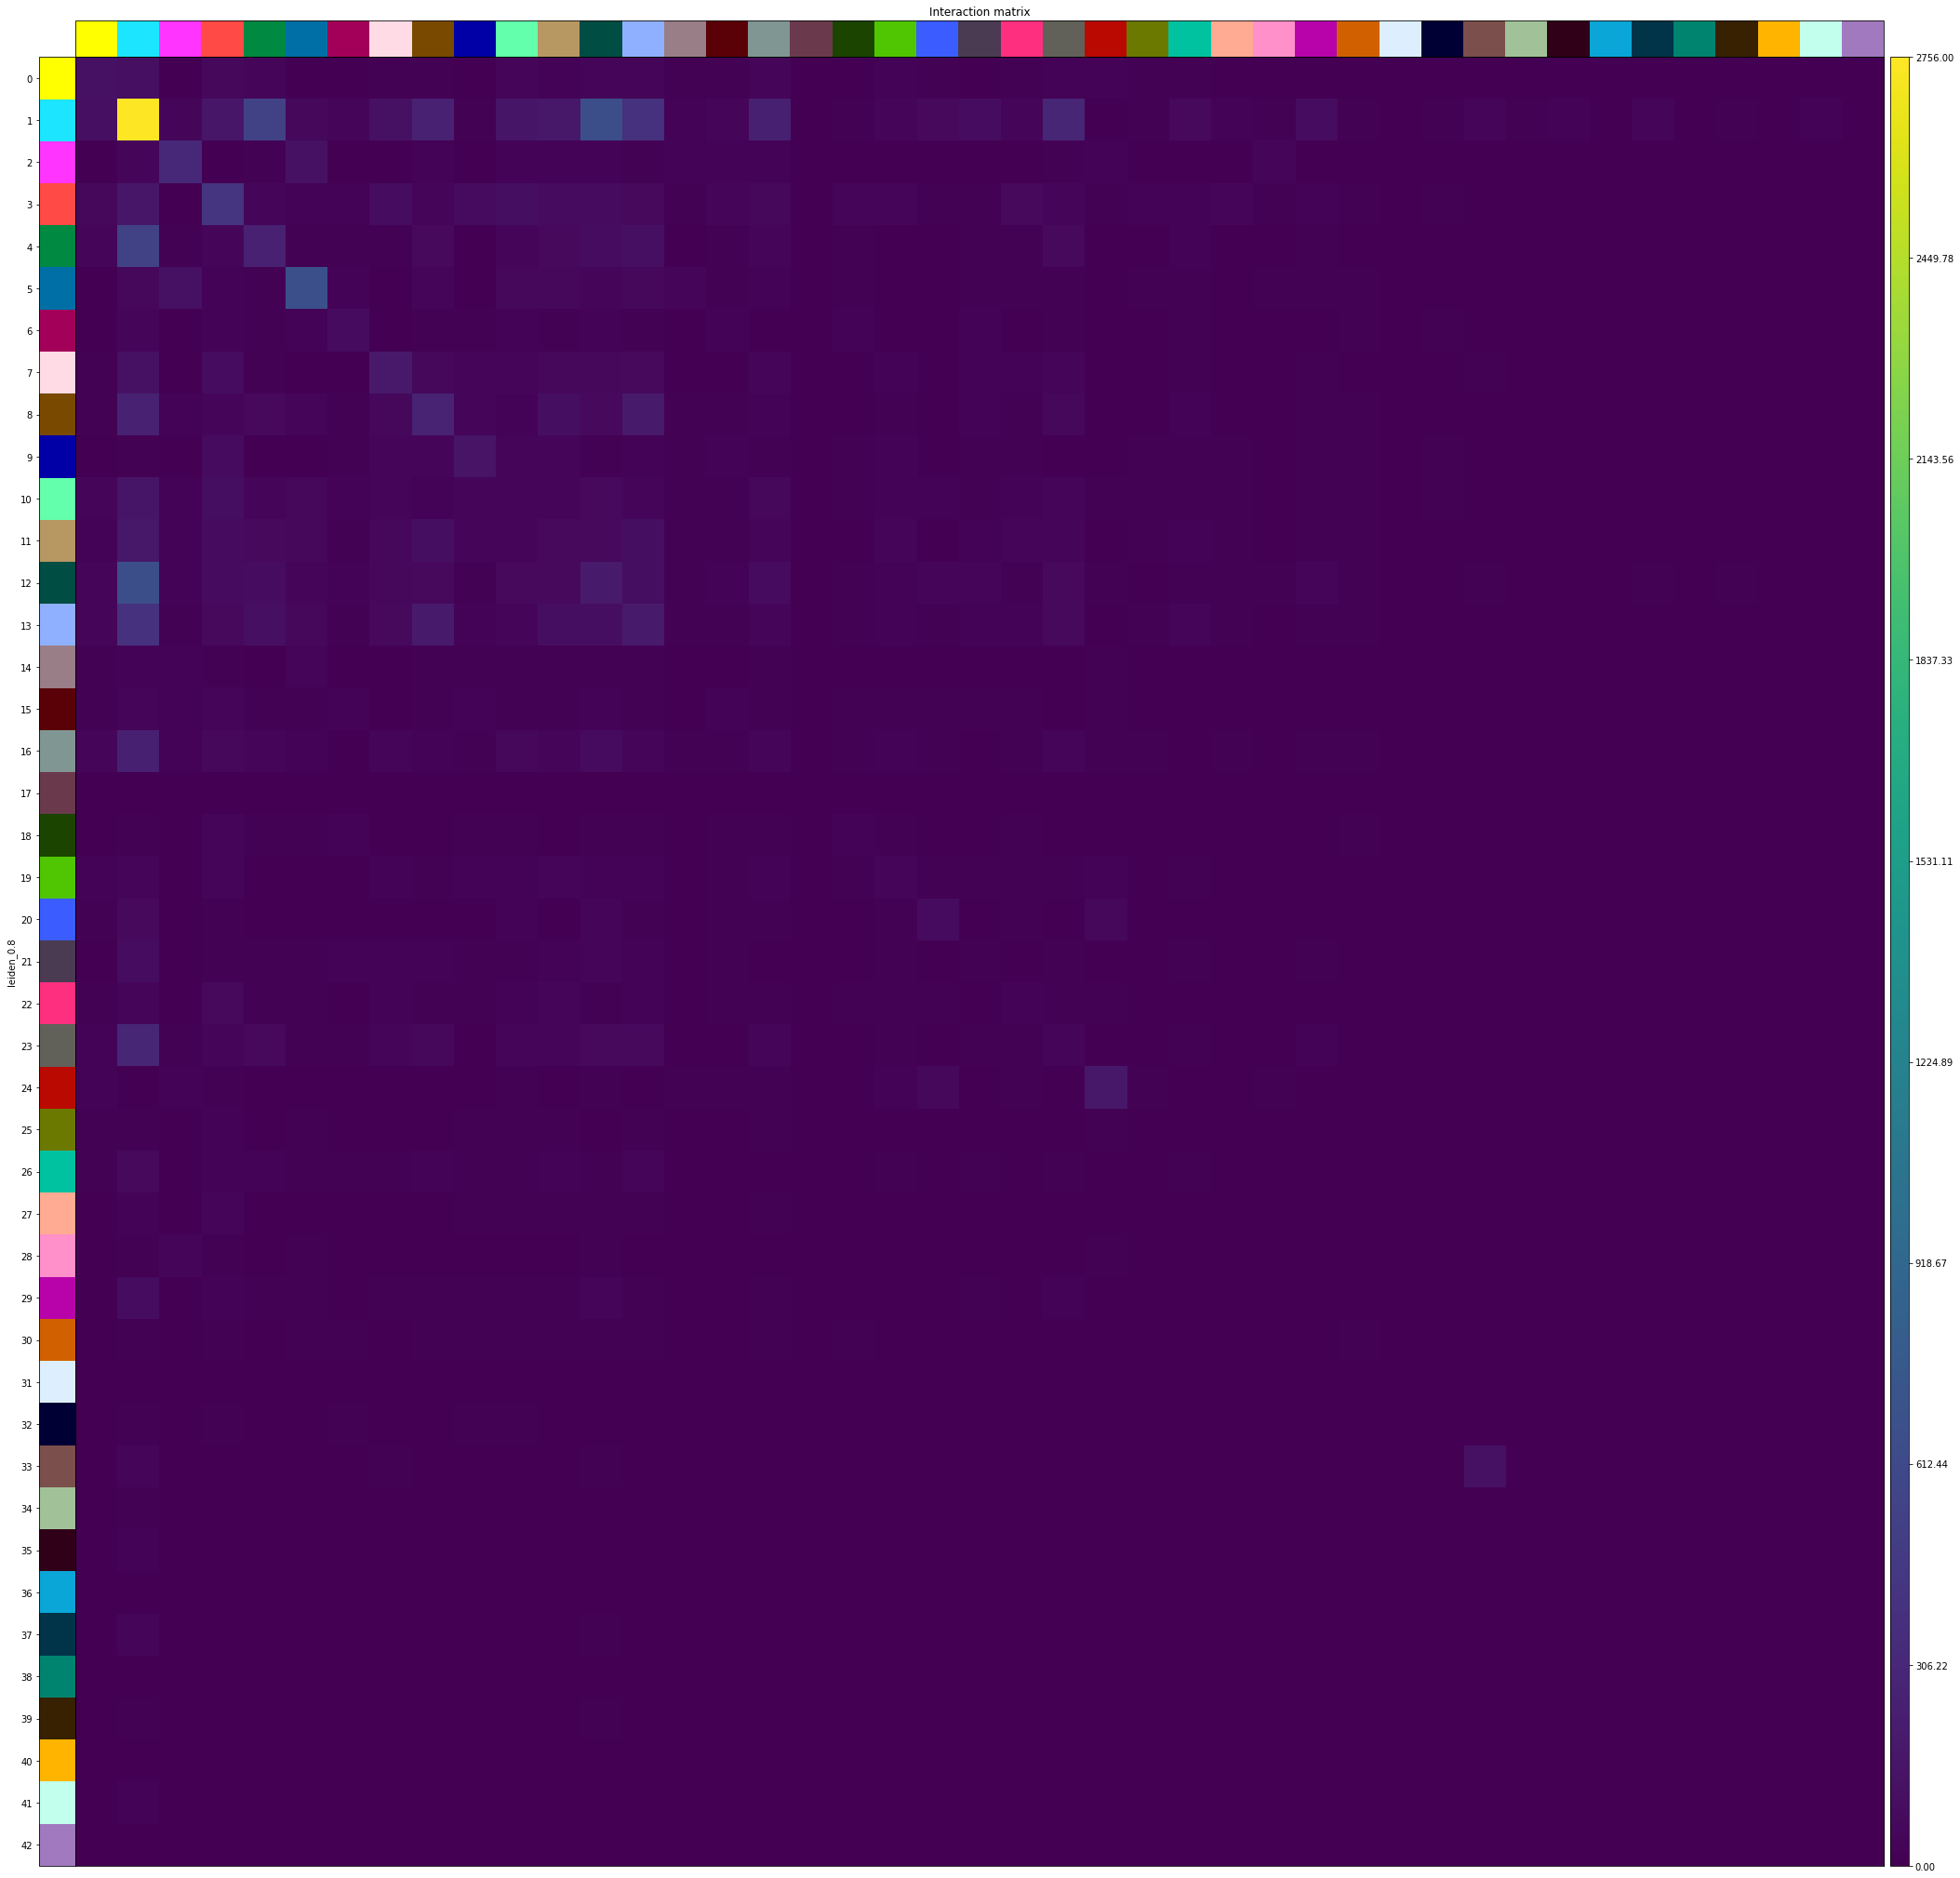

In [27]:
sq.gr.interaction_matrix(adata, cluster_key="leiden_0.8")
sq.pl.interaction_matrix(adata, cluster_key="leiden_0.8")

# Co-occurence of clusters

In addition to the neighbor enrichment score, we can visualize cluster co-occurrence in spatial dimensions. This is a similar analysis of the one presented above, yet it does not operate on the connectivity matrix, but on the original spatial coordinates. The co-occurrence score is the conditional probability of observing a cluster  conditioned on the presence of a cluster in the radius size of interest. The score is computed across increasing radii size around each cell in the tissue.

We can compute this score with squidpy.gr.co_occurrence() and set the cluster annotation for the conditional probability with the argument clusters. Then, we visualize the results with squidpy.pl.co_occurrence().

It can take a while to run the graph, so it's interesting to separate sq.gr.co_occurence() from sq.pl.co_occurrence() in two different chunks of code and just run the plot if we want to change anything

In [30]:
sq.gr.co_occurrence(adata, cluster_key="leiden_0.8")

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.99s/]


We plot how neiborhood enrichement change in depending on the distance used. We specify our key, so the variable that contains our cell types, together with the cluster that we use as a reference for calculating the enrichement from.

/home/sergio/anaconda3/envs/squidpy/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


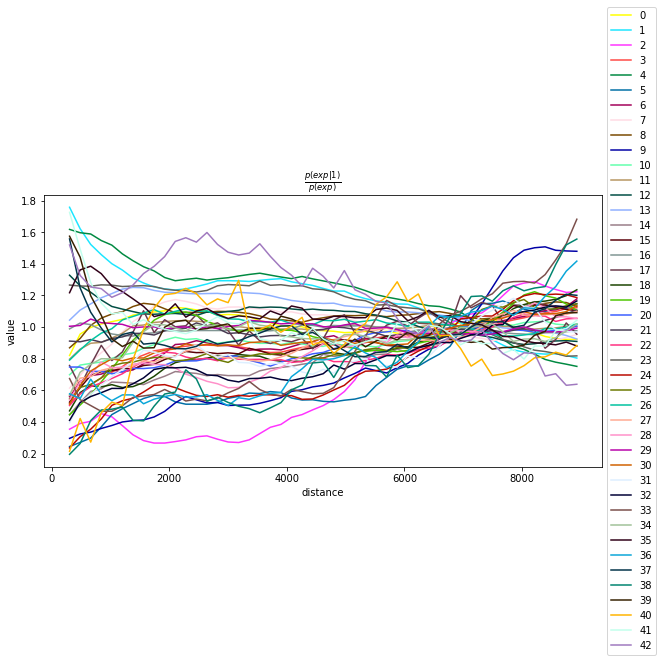

In [32]:
sq.pl.co_occurrence(
    adata,
    cluster_key="leiden_0.8",
    clusters="1",
    figsize=(10, 5),
)

# Properties of the spatial graph

Similar to the previous analysis, we can investigate properties of the spatial graph by computing different network centralities:

degree_centrality.

average_clustering.

closeness_centrality.

Squidpy provides a convenient function for all of them: squidpy.gr.centrality_scores() and squidpy.pl.centrality_scores() for visualization.

/home/sergio/anaconda3/envs/squidpy/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


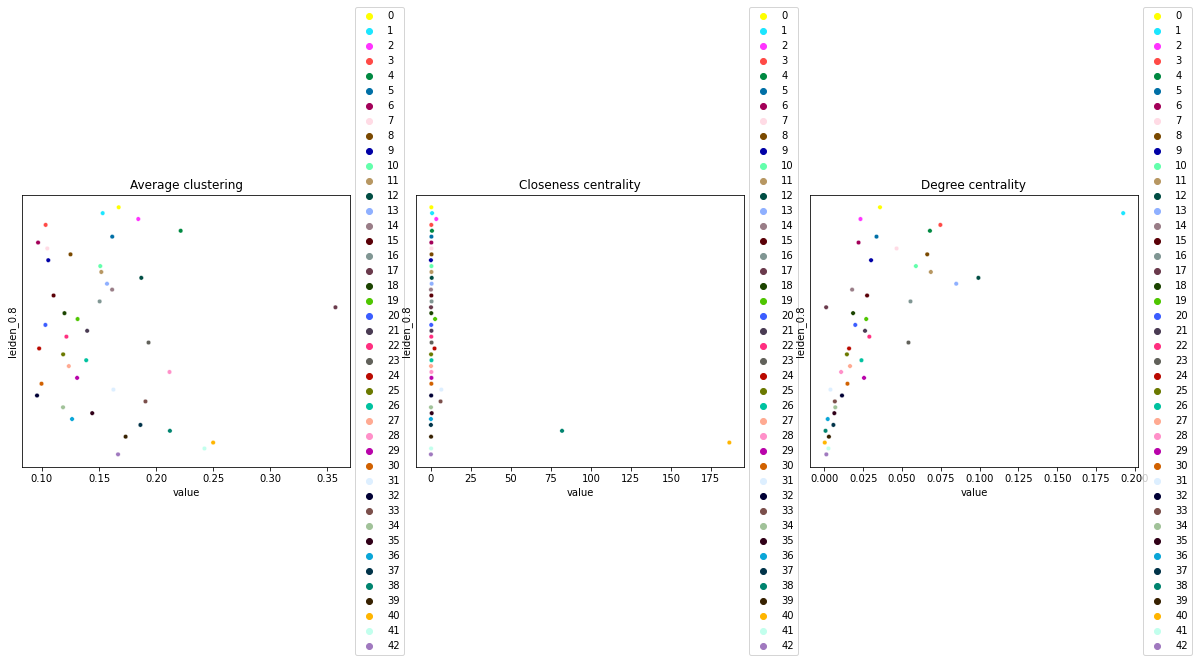

In [29]:
sq.gr.centrality_scores(
    adata,
    cluster_key="leiden_0.8",
)
sq.pl.centrality_scores(adata, cluster_key="leiden_0.8", figsize=(20, 5), s=20)

A summary of what the statistics meaning is:

-’average_clustering’ - measure of the degree to which nodes cluster together.
-’closeness_centrality’ - measure of how close the group is to other nodes.
-’degree_centrality’ - fraction of non-group members connected to group members.

More information can be found in this publication: https://www.biorxiv.org/content/10.1101/2020.02.17.947416v3

# Graph autocorrelation

With Squidpy we can investigate spatial variability of gene expression. squidpy.gr.spatial_autocorr() conveniently wraps two spatial autocorrelation statistics: Moran’s I and Geary’s C*. They provide a score on the degree of spatial variability of gene expression. The statistic as well as the p-value are computed for each gene, and FDR correction is performed. For the purpose of this tutorial, let’s compute the Moran’s I score. See Compute Moran’s I score for more details

In [33]:
sq.gr.spatial_autocorr(adata, mode="moran")
adata.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_norm_fdr_bh
Fzd5,0.380735,0.0,0.000073,0.0
Nrg1,0.327829,0.0,0.000073,0.0
Fgf8,0.324282,0.0,0.000073,0.0
Phox2b,0.320237,0.0,0.000073,0.0
Sim1,0.319108,0.0,0.000073,0.0
Pax6,0.316408,0.0,0.000073,0.0
Ntn1,0.308501,0.0,0.000073,0.0
En1,0.307473,0.0,0.000073,0.0
Sp8,0.304793,0.0,0.000073,0.0
Six6,0.272078,0.0,0.000073,0.0


# Spatial organization of cell types (Ripley's K)

In addition to the neighbor enrichment score, we can further investigate spatial organization of cell types in tissue by means of the Ripley’s statistics. Ripley’s statistics allow analyst to evaluate whether a discrete annotation (e.g. cell-type) appears to be clustered, dispersed or randomly distributed on the area of interest. In Squidpy, we implement three closely related Ripley’s statistics, that can be easily computed with squidpy.gr.ripley(). Here, we’ll showcase the Ripley’s L statistic, which is a variance-stabilized version of the Ripley’s K statistics. We’ll visualize the results with squidpy.pl.ripley(). Check Compute Ripley’s statistics for more details.



In [42]:
adata

AnnData object with n_obs × n_vars = 18466 × 119
    obs: 'x', 'y', 'area', 'cellid', 'n_counts', 'n_genes_by_counts', 'total_counts', 'leiden_0.2', 'leiden_0.5', 'leiden_0.8', 'sample', 'project'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'dendrogram_leiden_0.5', 'leiden', 'leiden_0.2_colors', 'leiden_0.5_colors', 'leiden_0.8_colors', 'neighbors', 'pca', 'sample_colors', 't-test', 'umap', 'spatial_neighbors', 'leiden_0.8_nhood_enrichment', 'leiden_0.8_interactions', 'leiden_0.8_centrality_scores', 'leiden_0.8_co_occurrence', 'moranI'
    obsm: 'X_pca', 'X_umap', 'X_xy_loc', 'spatial', 'xy_loc'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [43]:
mode = "L"
sq.gr.ripley(adata, cluster_key="leiden_0.8", mode=mode, max_dist=1000)
sq.pl.ripley(adata, cluster_key="leiden_0.8", mode=mode)

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1454533267  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 1.3e+04  Error-roundoff 1.8e-11  _one-merge 1.3e-10
  _near-inside 6.4e-10  Visible-distance 3.6e-11  U-max-coplanar 3.6e-11
  Width-outside 7.3e-11  _wide-facet 2.2e-10  _maxoutside 1.5e-10

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p18460(v4): 6.1e+03 1.3e+04 1.3e+04
- p182(v3): 7.5e+03 7.2e+02 7.2e+02
- p13971(v2): 1.3e+04 9e+03 9e+03
- p7916(v1): 3.3e+02 7.5e+03 7.5e+03

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.8e-11.  The center point, facets and distances
to the center point are as follows:

center point     6725     7579     7579

facet p182 p13971 p7916 distance=    0
facet p18460 p13971 p7916 distance=    0
facet p18460 p182 p7916 distance=    0
facet p18460 p182 p13971 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:     327.8  1.29e+04  difference= 1.258e+04
  1:     724.9  1.31e+04  difference= 1.237e+04
  2:     724.9  1.31e+04  difference= 1.237e+04

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.8e-11.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.
